In [1]:
from fmd_evolution import *
import esm # to use the PLM ESM-2
import os # to process evaluation data from MSA file
from Bio.Align import substitution_matrices

In [2]:
# Source: https://github.com/facebookresearch/esm/tree/main?tab=readme-ov-file#esmfold
model, alphabet = esm.pretrained.load_model_and_alphabet("esm2_t33_650M_UR50D") 
batch_converter = alphabet.get_batch_converter()

In [3]:
reference_seq = 'TTSAGESADPVTATVENYGGETQVQRRQHTDIAFILDRFVKVKPKEQVNVLDLMQIPAHTLVGALLRTATYYFSDLELAVKHEGDLTWVPNGAPETALDNTTNPTAYHKEPLTRLALPYTAPHRVLATVYNGSSKYGDTSTNNVRGDLQVLAQKAERTLPTSFNFGAIKATRVTELLYRMKRAETYCPRPLLAIQPSDARHKQRIVAPAKQ'

In [4]:
modelSingleton = ModelSingleton(model=model,alphabet=alphabet,batch_converter=batch_converter)

In [5]:
# mutation strategy parameters
mutations_per_seq = 4 # cap on size of potential mutation pool
constrained_start = 138 # start of high variability region
constrained_end = 143 # end of high variability region
num_of_mutations_desired=3 # number of mutations desired after filtering with mutation score


mh_iterations = 10
top_k_percent = 0.08 # 10% of pool of 114 possible mutations (6 amino acids at current positions excluded) = 11
mh_mutations_per_seq = 3 # number of amino acids generated per pos

# evaluation strategy parameters
max_generations = 7
alignment_file_path = os.path.join("fmd_evolution/evaluation", "FMDV_VP1_HVR_1571seq_aln.fas") # can only be applied on predictions with constrained positions 138-143 - can I push this to my repo? or not supposed to be public?
segment = list(reference_seq)[constrained_start-1:constrained_end] # constrained segment to mutate
ref_seq_id = ''.join(segment)
ref_seq_id = "base"

In [6]:
for pos in range(constrained_start,constrained_end+1):
    print(f"Position {pos} : Amino Acid {segment[pos-constrained_start]}")

Position 138 : Amino Acid D
Position 139 : Amino Acid T
Position 140 : Amino Acid S
Position 141 : Amino Acid T
Position 142 : Amino Acid N
Position 143 : Amino Acid N


## Evolution using Metropolis Hastings Across 6 Highly Mutable Positions

In [7]:
plm = ProteinLanguageModel()
fmd_sequence = plm.create_protein_sequence(id=ref_seq_id,sequence=reference_seq) # protein sequence object generator

In [8]:
mutation_strat = MetropolisHastings(iterations=mh_iterations, top_k_percent=top_k_percent, start_pos=constrained_start,end_pos=constrained_end) # to generate pool of mutations
eval_strat = EvaluationStrategy(root_sequence = fmd_sequence) # to score and to filter pool of mutations
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)

In [9]:
evolution.evolve_sequence() # find a way to shrink the pool (using the generation)

Number of possible_mutations = 114
K mutations (pool size) = 9
Pool of potential mutations: [('S', 140, 'K'), ('N', 142, 'T'), ('S', 140, 'Q'), ('D', 138, 'I'), ('S', 140, 'R'), ('N', 142, 'S'), ('T', 141, 'V')]
Parent: mutation:base, probability:0.80945, distance 0
Mutation accepted: S140K, probability: 0.81218, distance: 0.00056
Mutation accepted: N142T, probability: 0.81179, distance: 0.00054
Mutation accepted: S140Q, probability: 0.81264, distance: 0.00046
Mutation accepted: S140R, probability: 0.81326, distance: 0.00077
Mutation accepted: N142S, probability: 0.81091, distance: 0.00039
Mutation accepted: T141V, probability: 0.81107, distance: 0.00074
Viable mutations: ['S140K', 'N142T', 'S140Q', 'S140R', 'N142S', 'T141V']
Number of possible_mutations = 114
K mutations (pool size) = 9
Pool of potential mutations: [('T', 139, 'S'), ('N', 142, 'D'), ('K', 140, 'R'), ('N', 142, 'T'), ('N', 142, 'S'), ('T', 139, 'H'), ('T', 141, 'A'), ('T', 139, 'R')]
Parent: mutation:S140K, probability

In [10]:
# evolution.evolve_sequence() # positions are 0-indexed, adjusted later for graph, fitness landscape, mutation score z axis, y axis pos 1 (all possible aas), y pos 2 (same), order the aminoa cids correctly! using embeddings for what's similar/close

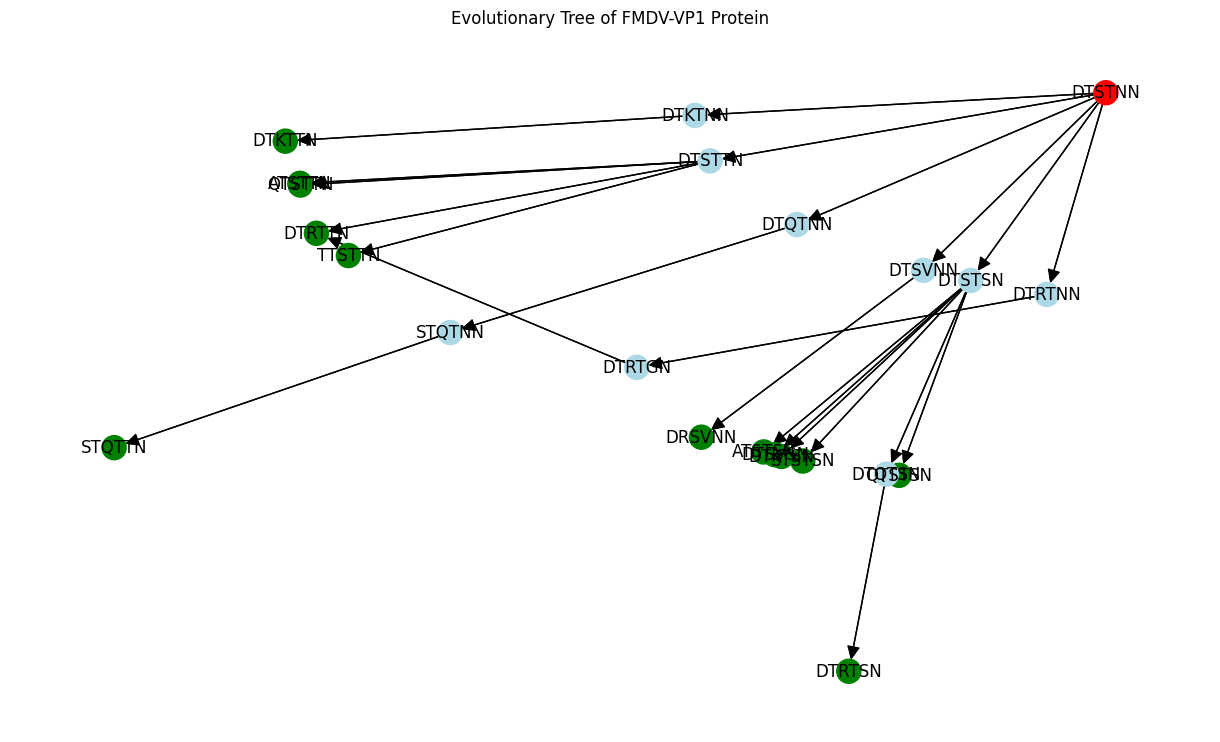

In [11]:
evolution.visualise_graph() 

In [12]:
sorted_paths = evolution.get_paths() # paths to leaf nodes only
num_of_paths = len(sorted_paths)
print(f"Number of paths generated: {num_of_paths}") # sorted by mean mutation score for path

Number of paths generated: 13


Path 1 average mutation score: 0


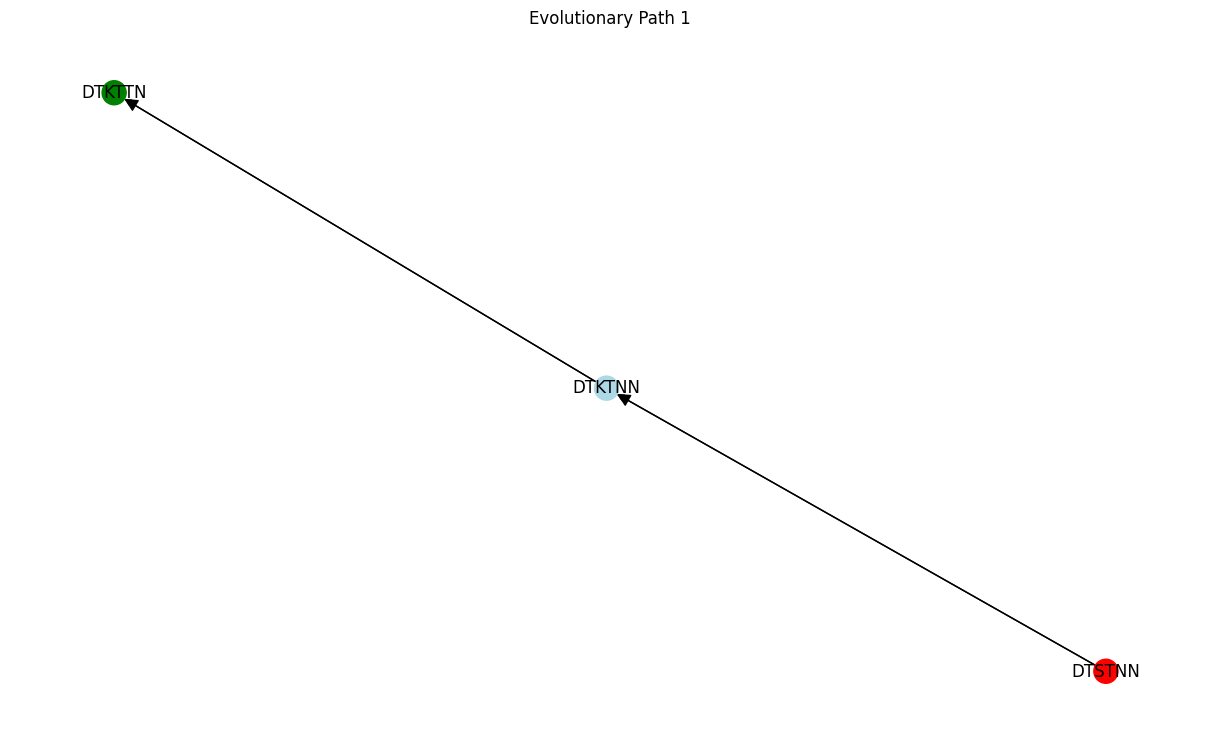

Path 2 average mutation score: 0


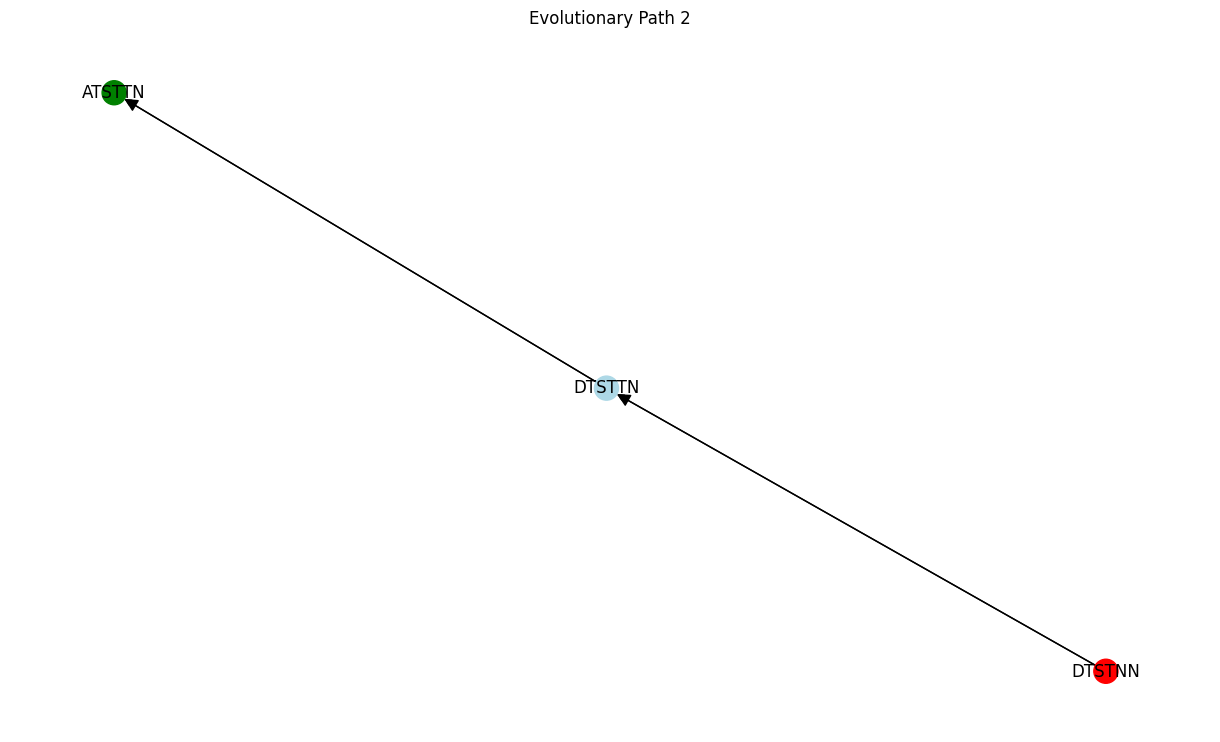

Path 3 average mutation score: 0


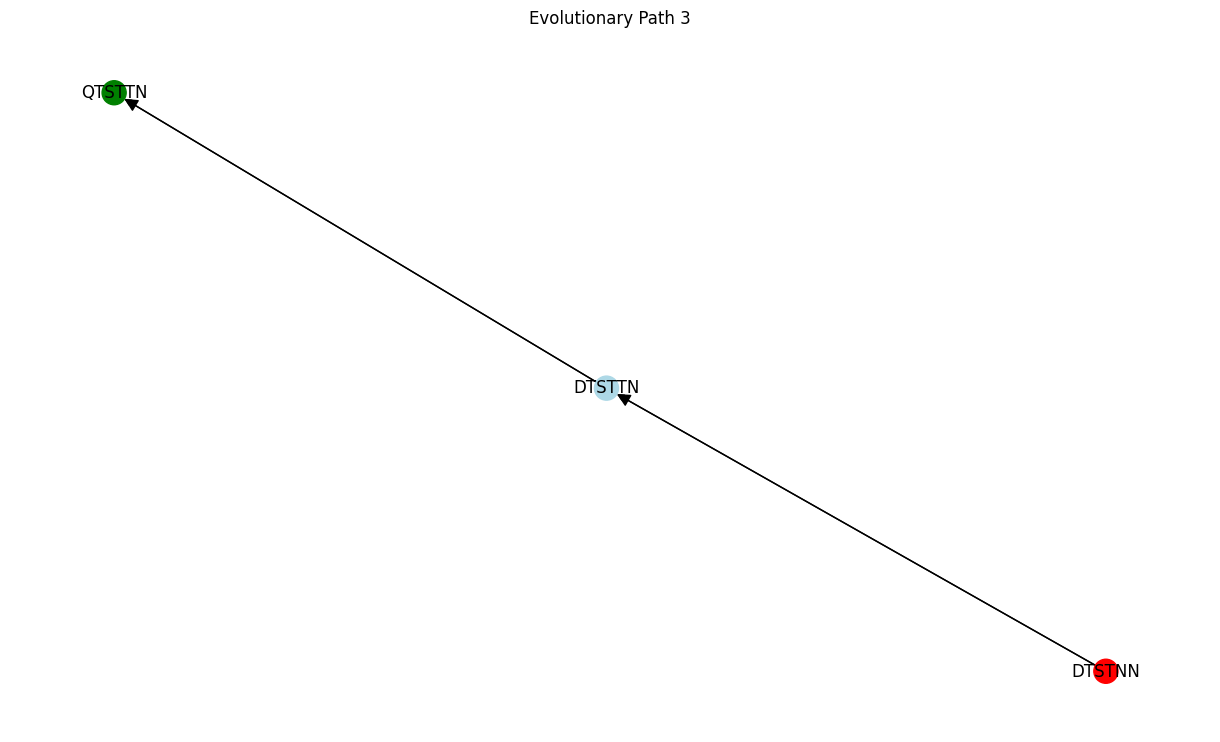

Path 4 average mutation score: 0


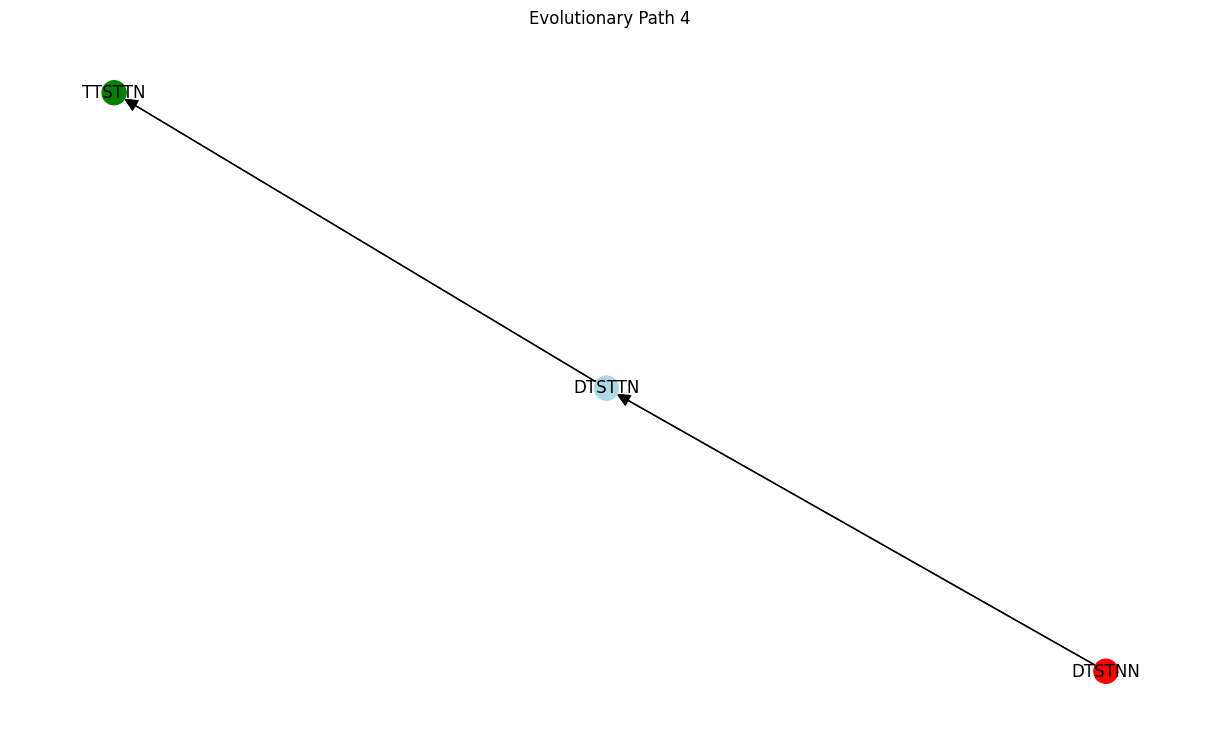

Path 5 average mutation score: 0


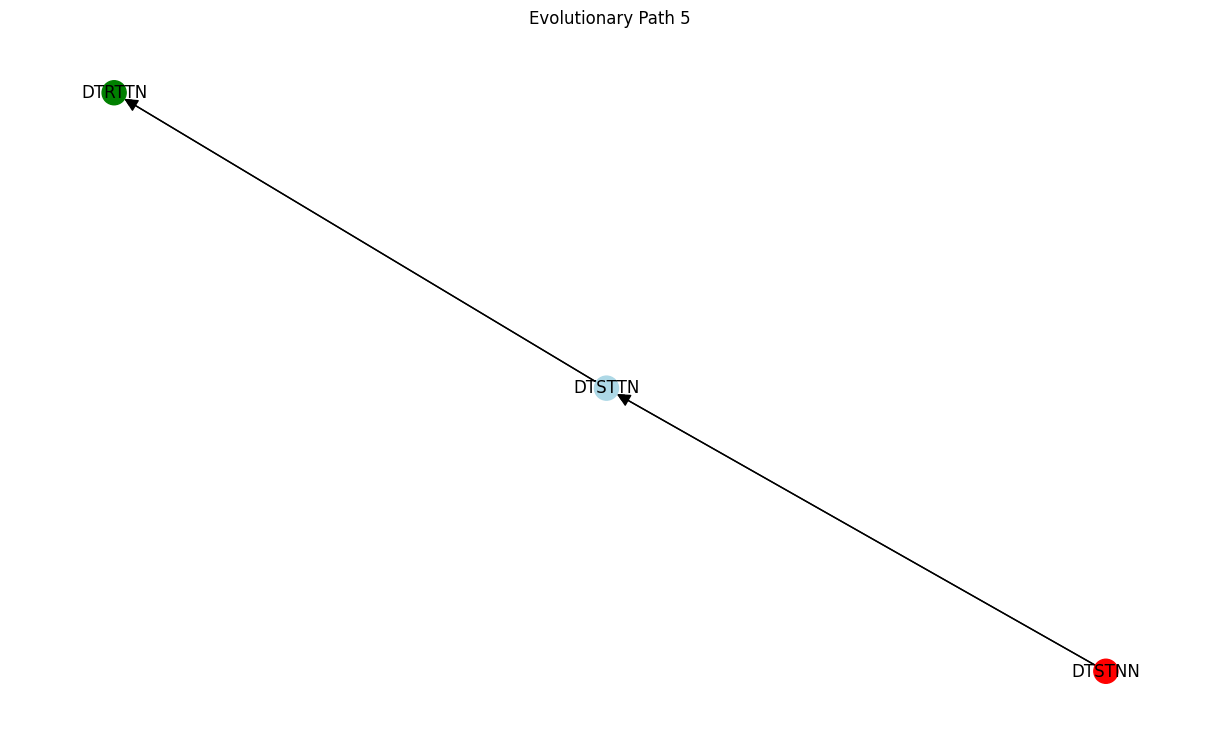

Path 6 average mutation score: 0


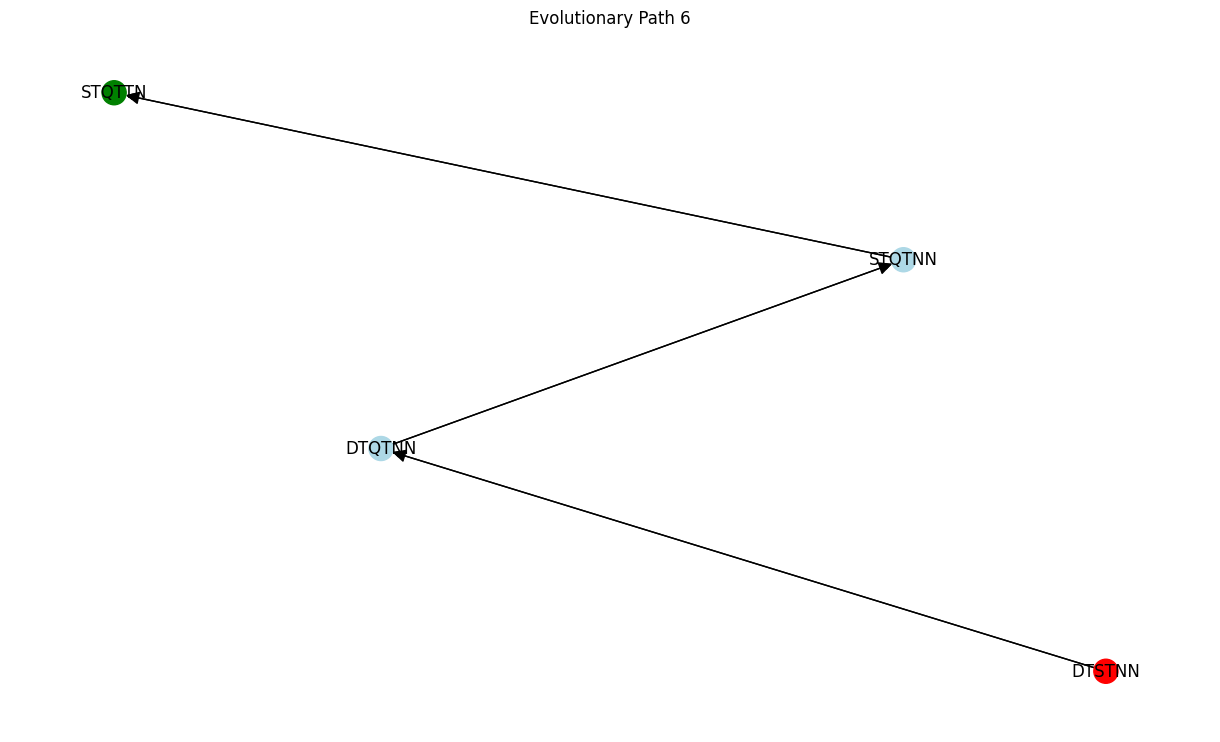

Path 7 average mutation score: 0


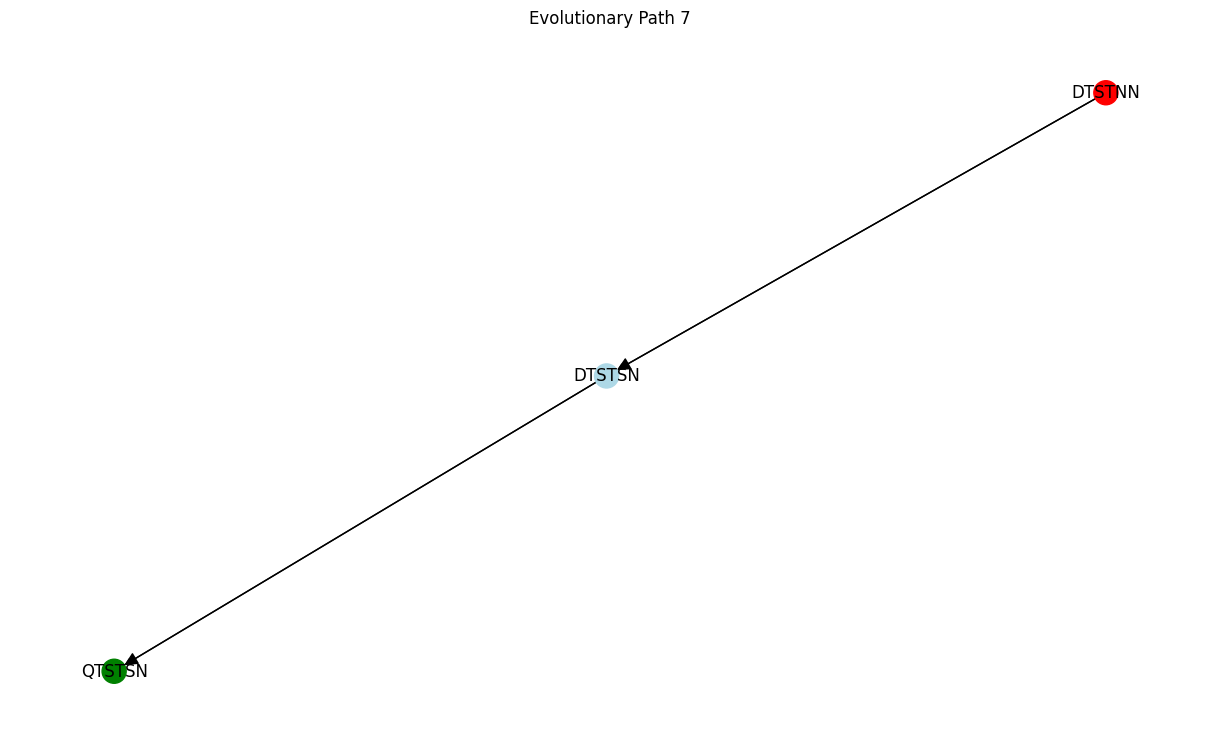

Path 8 average mutation score: 0


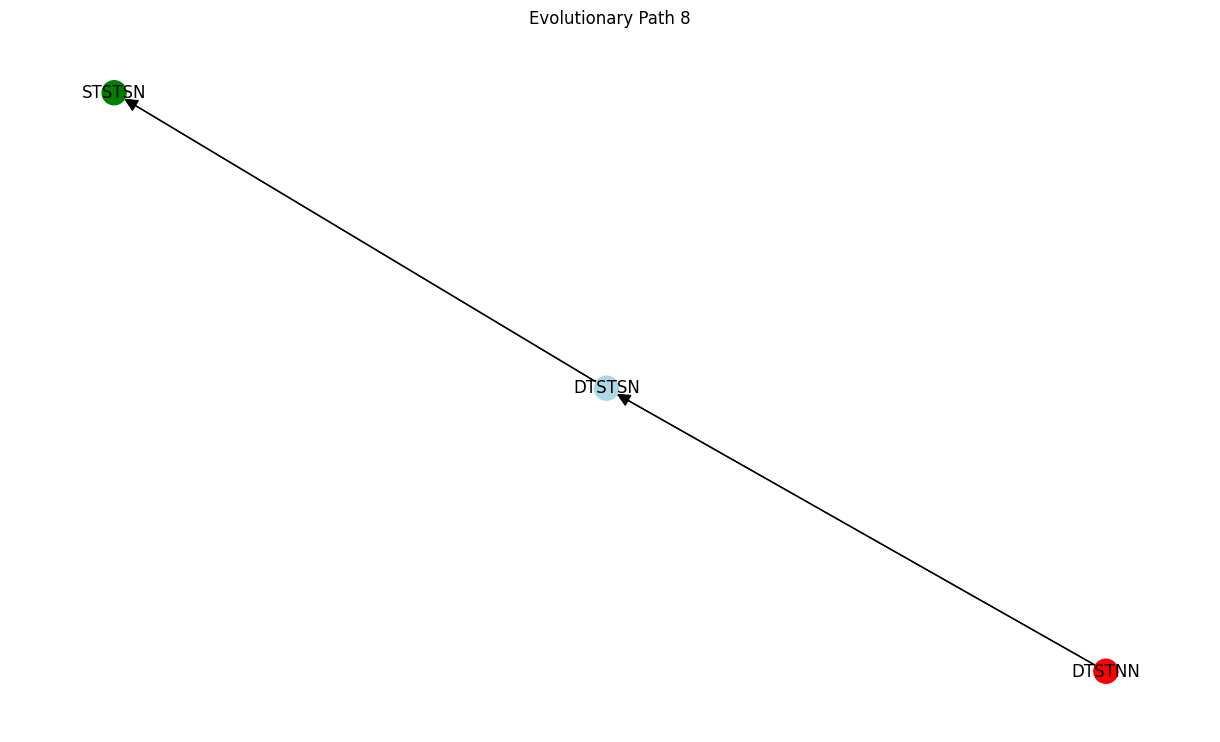

Path 9 average mutation score: 0


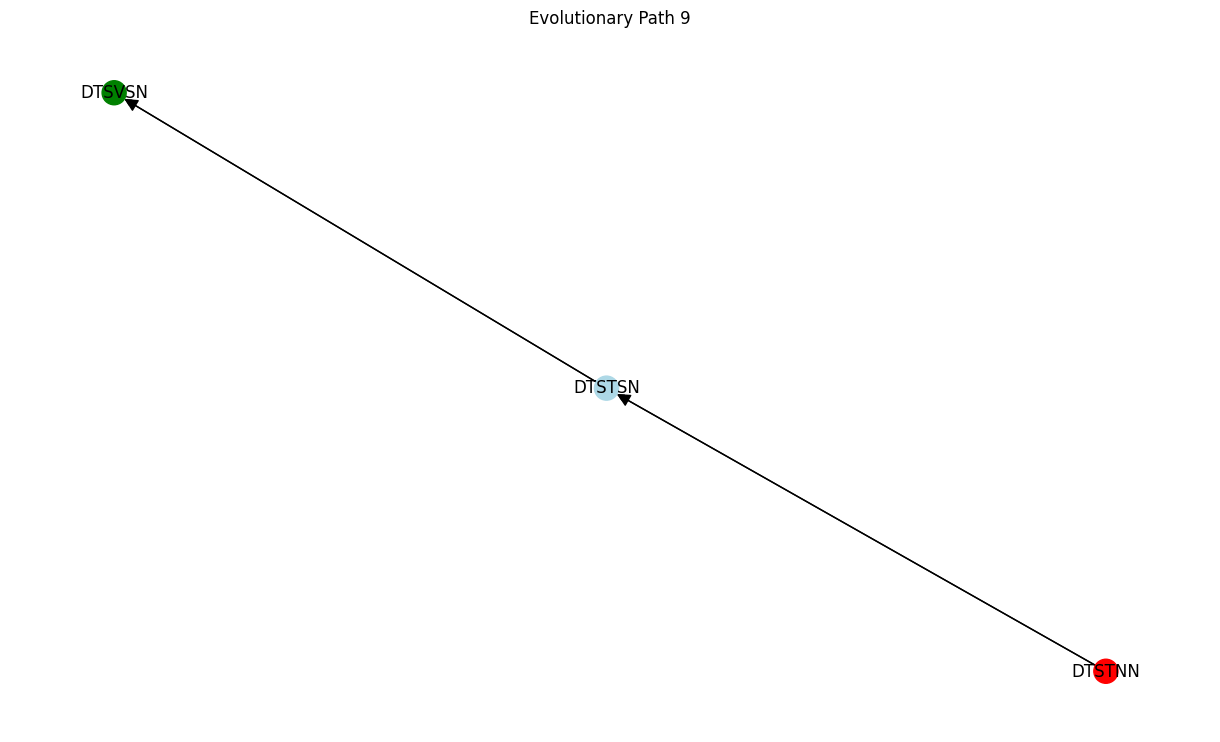

Path 10 average mutation score: 0


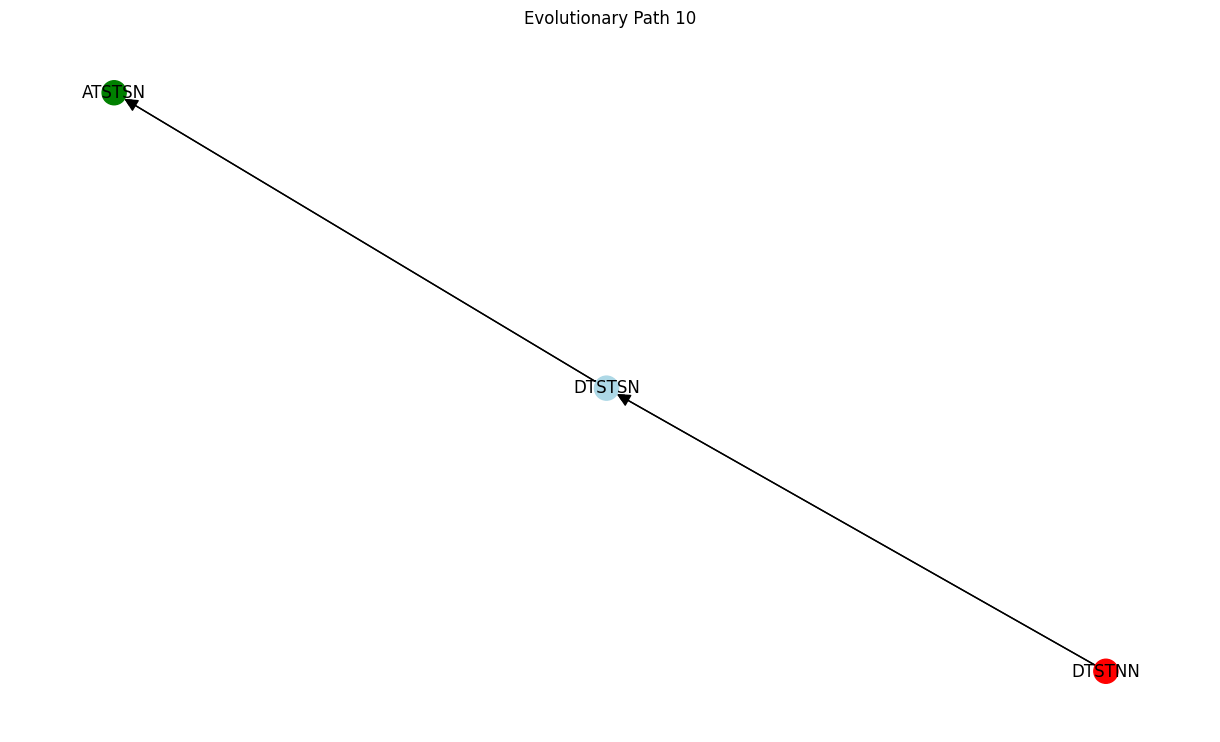

Path 11 average mutation score: 0


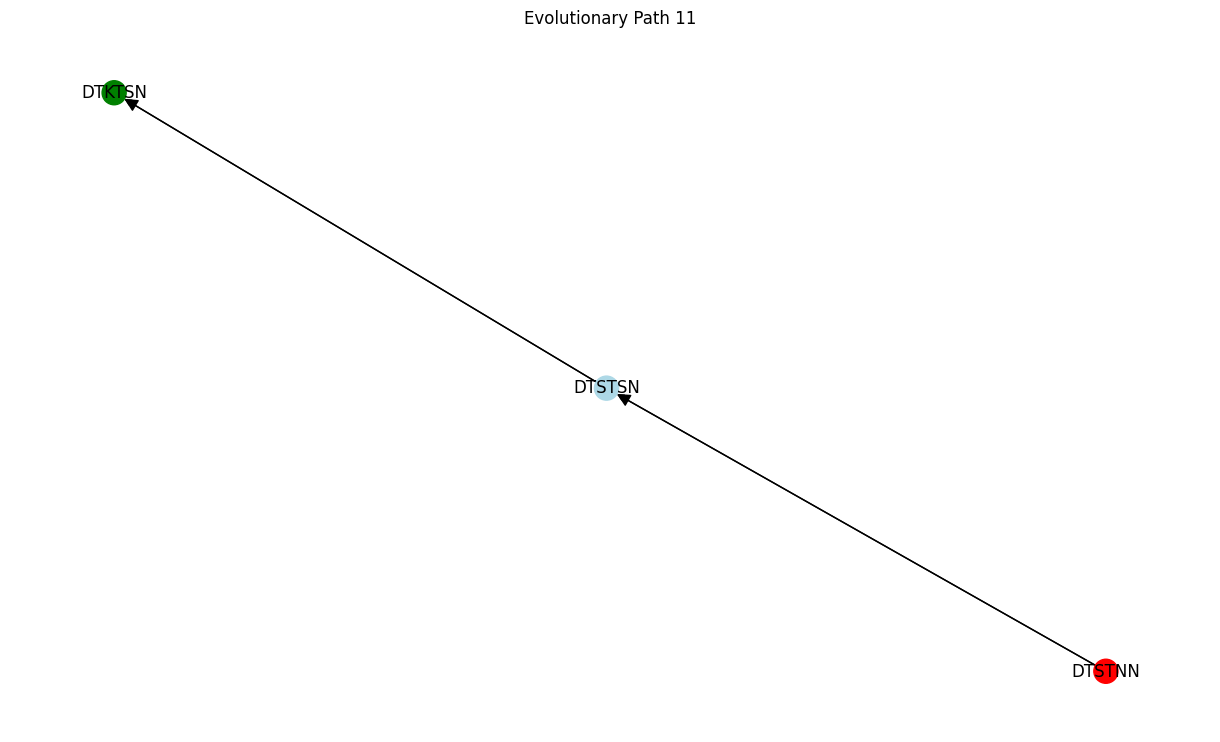

Path 12 average mutation score: 0


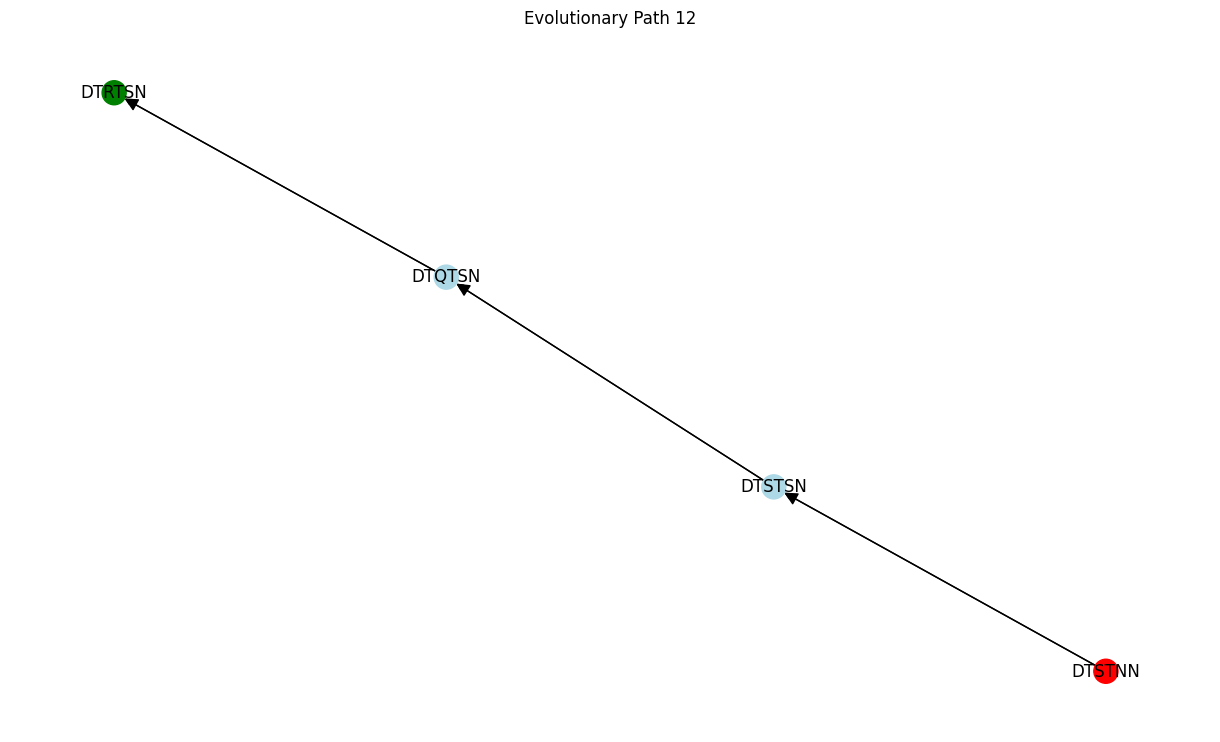

Path 13 average mutation score: 0


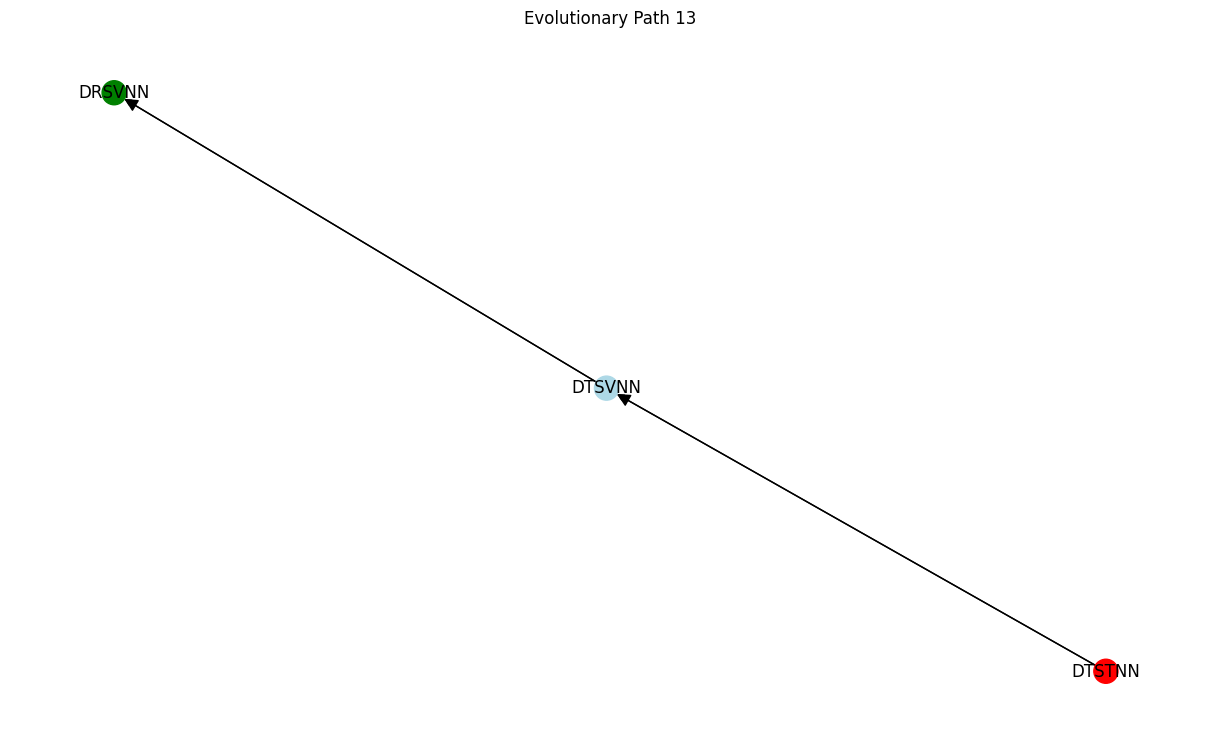

In [13]:
for i in range(num_of_paths):
    average_mutation_score,path = sorted_paths[i]
    path_name = i+1 # start from Path 1
    print(f"Path {path_name} average mutation score: {average_mutation_score}")
    evolution.visualise_graph(path=path,title=f"Evolutionary Path {path_name}")

In [14]:
evaluator = Evaluation(
    tree = evolution.G,
    alignment_file_path = alignment_file_path,
    start_pos = constrained_start,
    ref_seq_id = ref_seq_id
)

paths_mutation_matches,paths_final_segment_matches,paths_consecutive_pair_matches = evaluator.get_paths_metric_data(sorted_paths)

Paths: [['DTKTNN', 'DTKTTN'], ['DTSTTN', 'ATSTTN'], ['DTSTTN', 'QTSTTN'], ['DTSTTN', 'TTSTTN'], ['DTSTTN', 'DTRTTN'], ['DTQTNN', 'STQTNN', 'STQTTN'], ['DTSTSN', 'QTSTSN'], ['DTSTSN', 'STSTSN'], ['DTSTSN', 'DTSVSN'], ['DTSTSN', 'ATSTSN'], ['DTSTSN', 'DTKTSN'], ['DTSTSN', 'DTQTSN', 'DTRTSN'], ['DTSVNN', 'DRSVNN']]


Path 1:[0.0, 0.38]
Path 2:[0.38, 0.02]
Path 3:[0.38, 0.01]
Path 4:[0.38, 0.05]
Path 5:[0.38, 0.38]
Path 6:[0.01, 0.0, 0.38]
Path 7:[0.14, 0.01]
Path 8:[0.14, 0.0]
Path 9:[0.14, 0.26]
Path 10:[0.14, 0.02]
Path 11:[0.14, 0.0]
Path 12:[0.14, 0.01, 0.03]
Path 13:[0.26, 0.0]


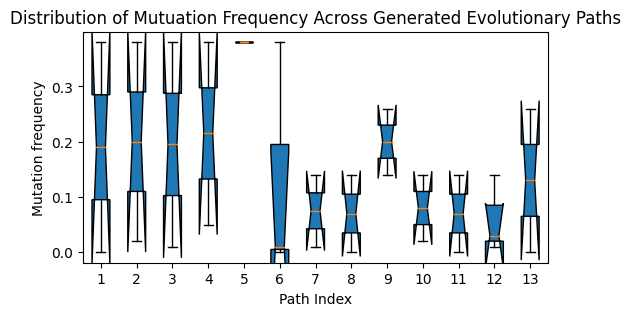

In [15]:
evaluator.box_plot_path_mutation_matches(paths_mutation_matches)
for i in range(num_of_paths):
    print(f"Path {i+1}:{paths_mutation_matches[i]}")

Path 1:[0.0]
Path 2:[0.02]
Path 3:[0.0]
Path 4:[0.04]
Path 5:[0.38]
Path 6:[0.0, 0.0]
Path 7:[0.0]
Path 8:[0.0]
Path 9:[0.01]
Path 10:[0.0]
Path 11:[0.0]
Path 12:[0.0, 0.0]
Path 13:[0.0]


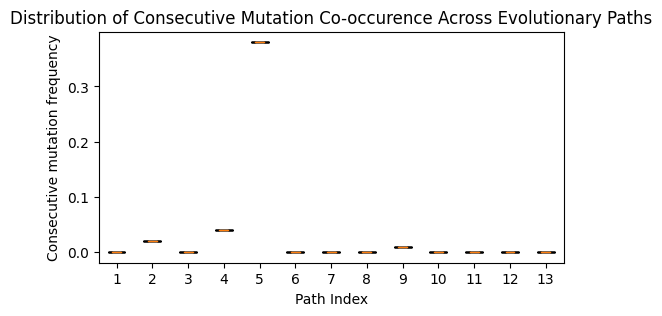

In [16]:
evaluator.box_plot_path_consecutive_pair_matches(paths_consecutive_pair_matches)
for i in range(num_of_paths):
    print(f"Path {i+1}:{paths_consecutive_pair_matches[i]}")

Path 1:0.0
Path 2:0.0
Path 3:0.0
Path 4:0.0
Path 5:0.0
Path 6:0.0
Path 7:0.0
Path 8:0.0
Path 9:0.0
Path 10:0.0
Path 11:0.0
Path 12:0.0
Path 13:0.0


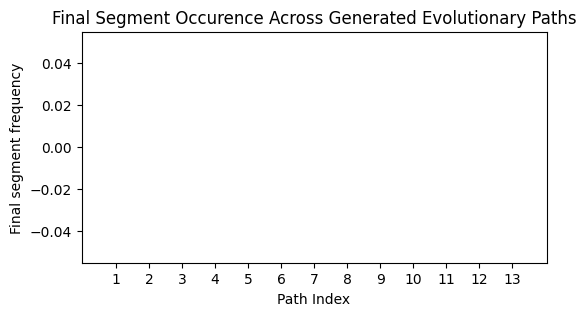

In [17]:
evaluator.bar_plot_path_final_segment_matches(paths_final_segment_matches)
for i in range(num_of_paths):
    print(f"Path {i+1}:{paths_final_segment_matches[i]}")

## Evolution using Metropolis Hastings Across All 212 Positions

In [18]:
min_pos = 1
max_pos = 212

In [19]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence = fmd_sequence)
mutation_strat = mutation_strat = MetropolisHastings(iterations=mh_iterations, positions_per_seq=mh_positions_per_seq, mutations_per_seq=mh_mutations_per_seq, start_pos=min_pos,end_pos=max_pos)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)

TypeError: log(): argument 'input' (position 1) must be Tensor, not NoneType

In [ ]:
evolution.evolve_sequence() 

In [ ]:
evolution.visualise_graph() 

In [ ]:
sorted_best_paths = evolution.get_best_paths_in_order() # paths to leaf nodes only
print(f"Number of paths generated: {len(sorted_best_paths)}") # sorted by mean mutation score for path

In [ ]:
best_path = sorted_best_paths[0][1]
evolution.visualise_graph(best_path)

In [ ]:
worst_path = sorted_best_paths[-1][1]
evolution.visualise_graph(worst_path)

## Evolution using Mininimum and Maximum Logits Across 6 Highly Mutable Positions

In [ ]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence=fmd_sequence)
mutation_strat = MinLogitPosSub(mutations_per_seq=mutations_per_seq,start_pos=constrained_start,end_pos=constrained_end)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)
evolution.process_alignment_data(file_path) # process alignment data

In [ ]:
evolution.evolve_sequence()  

In [ ]:
evolution.visualise_graph() 

In [ ]:
sorted_best_paths = evolution.get_best_paths_in_order() # paths to leaf nodes only
print(f"Number of paths generated: {len(sorted_best_paths)}") # sorted by mean mutation score for path
# improve evaluation and leave it to filter out potential mutations rather than hardsetting, accept/reject policy, 
# what if i generate 100 different paths, what's the most likely paths that come up? rank these paths, want a population of possible paths  
# use alignments to assess closeness to actual path - ways to evaluate this and quantify the difference 

In [ ]:
best_path = sorted_best_paths[0][1]
evolution.visualise_graph(best_path)
evolution.evaluate_path_using_alignments(evolutionary_path=best_path)

In [ ]:
worst_path = sorted_best_paths[-1][1]
evolution.visualise_graph(worst_path)
evolution.evaluate_path_using_alignments(evolutionary_path=worst_path)

## Evolution using Mininimum-and Maximum Logits Across All 212 Positions

In [ ]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence = fmd_sequence)
mutation_strat = MinLogitPosSub(mutations_per_seq=mutations_per_seq,start_pos=min_pos,end_pos=max_pos)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)

In [ ]:
evolution.evolve_sequence() 

In [ ]:
evolution.visualise_graph()

In [ ]:
best_path = sorted_best_paths[0][1]
evolution.visualise_graph(best_path)

In [ ]:
worst_path = sorted_best_paths[-1][1]
evolution.visualise_graph(worst_path)

## Evolution using Blosum-Weighted Logits Across 6 Highly Mutable Positions

In [ ]:
blosum_matrix = substitution_matrices.load("BLOSUM80") 
multiplier=0.5 # for weighting blosum penalty 

In [ ]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence=fmd_sequence)
mutation_strat = BlosumWeightedSub(mutations_per_seq=mutations_per_seq,blosum_matrix=blosum_matrix,multiplier=multiplier,start_pos=constrained_start,end_pos=constrained_end)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)
evolution.process_alignment_data(file_path) # process alignment data

In [ ]:
evolution.evolve_sequence()   

In [ ]:
evolution.visualise_graph()

In [ ]:
sorted_best_paths = evolution.get_best_paths_in_order() # paths to leaf nodes only
print(f"Number of paths generated: {len(sorted_best_paths)}") # sorted by mean mutation score for path

In [ ]:
best_path = sorted_best_paths[0][1]
evolution.visualise_graph(best_path)
evolution.evaluate_path_using_alignments(evolutionary_path=best_path)

In [ ]:
worst_path = sorted_best_paths[-1][1]
evolution.visualise_graph(worst_path)
evolution.evaluate_path_using_alignments(evolutionary_path=worst_path)

## Evolution using Blosum-Weighted Logits Across All 212 Positions

In [ ]:
fmd_sequence = ProteinSequence("base",reference_seq)
eval_strat = EvaluationStrategy(root_sequence = fmd_sequence)
mutation_strat = BlosumWeightedSub(mutations_per_seq=mutations_per_seq,blosum_matrix=blosum_matrix,multiplier=multiplier,start_pos=min_pos,end_pos=max_pos)
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)

In [ ]:
evolution.evolve_sequence()   

In [ ]:
evolution.visualise_graph()

In [ ]:
sorted_best_paths = evolution.get_best_paths_in_order() # paths to leaf nodes only
print(f"Number of paths generated: {len(sorted_best_paths)}") # sorted by mean mutation score for path

In [ ]:
best_path = sorted_best_paths[0][1]
evolution.visualise_graph(best_path)

In [ ]:
worst_path = sorted_best_paths[-1][1]
evolution.visualise_graph(worst_path)

In [ ]:
# prior to changing should_continue_mutating from checking if sequence probability is increasing to checking if overall mutatioon score is increasing and using the minimum average logit score per position rather than the minimum aa logit value
# experiment observation: constraining positions for mutation increases length of evolution path  
# this is not surprising as mutating the position least favoured by the PLM != mutating the position that will yield an increase in sequence probability 
# replacing the current amino acid at the lowest logit position does not automatically increase the sequence probability 
# this is because it may choose a position where mutations are unlikely to happen at to begin  with (ie highly conserved regions) 
# thus leading to an overall decrease on the sequence probability and structure similarity
# When mutations are contrained to positions we know are highly variable from observed data, this aligns with the PLM's knowledge of existing mutations
# such that mutating these highly variable position can lead to higher probability sequences as it expects mutations to occur in these positions